In [1]:
import igraph
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import json
import networkx as nx
plt.style.use('ggplot')

# 1. Stock market

In [2]:
# Load in stock market data
df_name_sector = pd.read_csv ('finance_data/Name_sector.csv')
file_names = [_ for _ in os.listdir('finance_data/data') if _.endswith('.csv')]
file_names.sort()
df_list = []

for iFile in file_names:
    df_list.append(pd.read_csv ('finance_data/data/' + iFile))
    
# Remove incomplete data sets
pop_list = []
for i,idf in enumerate(df_list):
    if idf.shape != df_list[0].shape:
        pop_list.append(i)
    
for index in sorted(pop_list, reverse=True): 
    del df_list[index]
    del file_names[index]
    
df_name_sector = df_name_sector.drop(pop_list)
sector_dict = dict(zip(df_name_sector.Symbol, df_name_sector.Sector))

In [3]:
# Get log norm return from given column of dataframe
def get_log_return(df_list,column = 'Close'):

    log_return_mat = np.empty((len(df_list),df_list[0].shape[0]-1))

    for i,idf in enumerate(df_list):
        close_prices = idf.loc[:,column].values
        q = np.diff(close_prices)/close_prices[0:-1]
        log_return_mat[i,:] = np.log(1 + q)
        
    return log_return_mat
    
# Create a ncol style correlation graph file with edge weights
def create_graph_file(filepath,df_list,log_return_mat):
    ncol_file = open(filepath,'w')
    p_vec = []
    for i in range(0,len(df_list)):
        for j in range (i+1,len(df_list)):
            if i == j: continue
                
            r_i = np.mean(log_return_mat[i,:])
            r_j = np.mean(log_return_mat[j,:])
            r_ij = np.mean(log_return_mat[i,:] * log_return_mat[j,:])
            r_i_sq = np.mean(np.square(log_return_mat[i,:]))
            r_j_sq = np.mean(np.square(log_return_mat[j,:]))
            
            p_ij = (r_ij - r_i*r_j)/np.sqrt((r_i_sq-np.square(r_i))*(r_j_sq-np.square(r_j)))
            p_vec.append(p_ij)
            w_ij = np.sqrt(2*(1-p_ij))
            
            ncol_file.write(' '.join([file_names[i][:-4],file_names[j][:-4],str(w_ij)+ '\n']))
            
    ncol_file.close()
    return p_vec
            
p_vec = create_graph_file('correlation_graph.txt',df_list,get_log_return(df_list))

## 1. Return correlation

Text(0.5, 0, 'Weight')

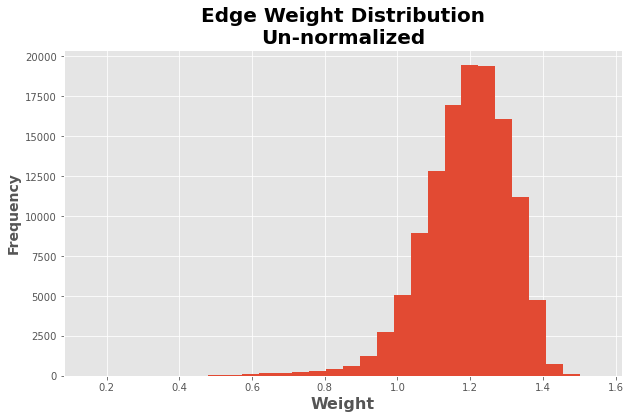

In [4]:
# Question 2

g = igraph.read('correlation_graph.txt', format="ncol", directed=False, names=True)
plt.figure(figsize=(10,6))
plt.hist(g.es['weight'], bins=30)
plt.title('Edge Weight Distribution\nUn-normalized',fontweight='bold',fontsize = 20)
plt.ylabel('Frequency',fontweight='bold',fontsize = 14)
plt.xlabel('Weight',fontweight='bold',fontsize = 16)

Vertices in Min Spanning Tree: 494
Edges in Min Spanning Tree: 493


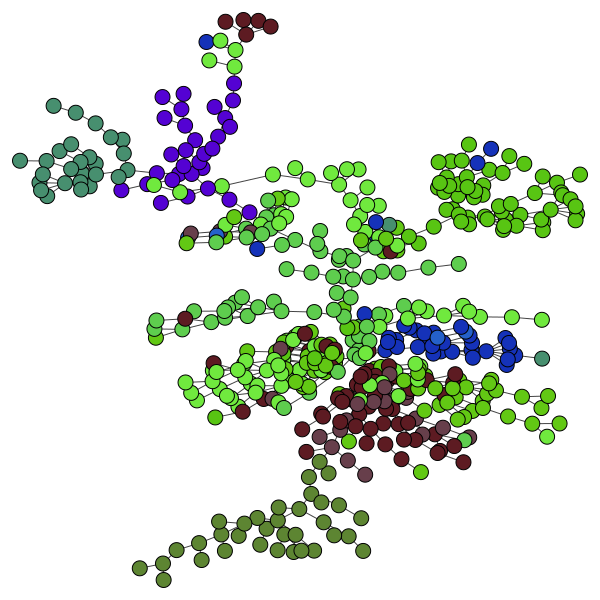

In [5]:
# Question 3

# Min Spanning tree considering weights
min_span_tree = g.spanning_tree(g.es['weight'])
print('Vertices in Min Spanning Tree: {}'.format(min_span_tree.vcount()))
print('Edges in Min Spanning Tree: {}'.format(min_span_tree.ecount()))

color =[]
sector_list = df_name_sector.Sector.unique().tolist()
for i in range(len(sector_list)): color.append('#%06X' % randint(0, 0xFFFFFF))

vector_colors = []
for iV in min_span_tree.vs['name']: vector_colors.append(color[sector_list.index(sector_dict[iV])])
    
igraph.plot(min_span_tree,target='min_sector1.png',vertex_size=15,vertex_color=vector_colors,layout="kk")


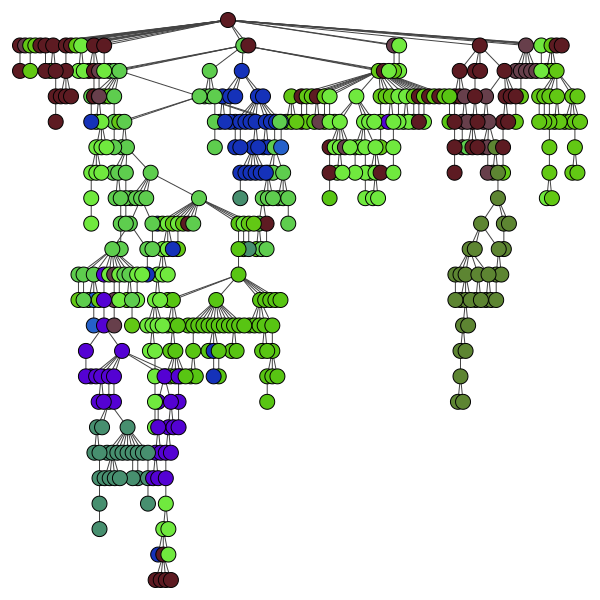

In [6]:
igraph.plot(min_span_tree,target='min_sector1.png',vertex_size=15,vertex_color=vector_colors,layout="tree")

In [7]:
# Question 4

S_list = df_name_sector.Sector.value_counts().tolist()

S = np.zeros(min_span_tree.vcount())
N = np.zeros(min_span_tree.vcount())
Q = np.zeros(min_span_tree.vcount())


for i,iV in enumerate(min_span_tree.vs):
    S[i] = df_name_sector.Sector.value_counts()[sector_dict[iV['name']]]
    
    neighbors = min_span_tree.neighborhood(iV)
    N[i] = len(neighbors)
    
    Q_i = 0
    for iN in neighbors: 
        if sector_dict[min_span_tree.vs[iN]['name']] == sector_dict[iV['name']]: 
            Q_i+=1 
    Q[i] = Q_i
    
alpha1 = np.sum(Q/N)/min_span_tree.vcount()
alpha2 = np.sum(S/min_span_tree.vcount())/min_span_tree.vcount()

print('Alpha Method 1: {}'.format(alpha1))
print('Alpha Method 2: {}'.format(alpha2))

Alpha Method 1: 0.898149713045858
Alpha Method 2: 0.1141880706125326


Vertices in Min Spanning Tree: 494
Edges in Min Spanning Tree: 493


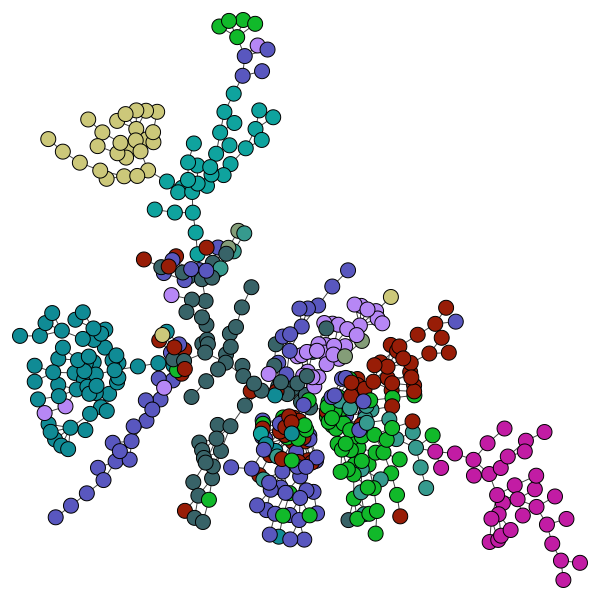

In [8]:
# Question 5

df_list_wk = []

weekdays = pd.to_datetime(df_list[0].Date).dt.dayofweek.to_numpy()
mondays = np.where(weekdays == 0)[0]

for i,idf in enumerate(df_list): df_list_wk.append(idf.loc[mondays])

p_vec_wk = create_graph_file('correlation_graph_weekly_Mondays.txt',df_list_wk,get_log_return(df_list_wk))
g_wk = igraph.read('correlation_graph_weekly_Mondays.txt', format="ncol", directed=False, names=True)

# Min Spanning tree considering weights
min_span_tree_wk = g_wk.spanning_tree(g.es['weight'])
print('Vertices in Min Spanning Tree: {}'.format(min_span_tree_wk.vcount()))
print('Edges in Min Spanning Tree: {}'.format(min_span_tree_wk.ecount()))

color =[]
sector_list = df_name_sector.Sector.unique().tolist()
for i in range(len(sector_list)): color.append('#%06X' % randint(0, 0xFFFFFF))

vector_colors = []
for iV in min_span_tree_wk.vs['name']: vector_colors.append(color[sector_list.index(sector_dict[iV])])
    
igraph.plot(min_span_tree_wk,target='min_sector1_wk.png',vertex_size=15,vertex_color=vector_colors,layout="kk")

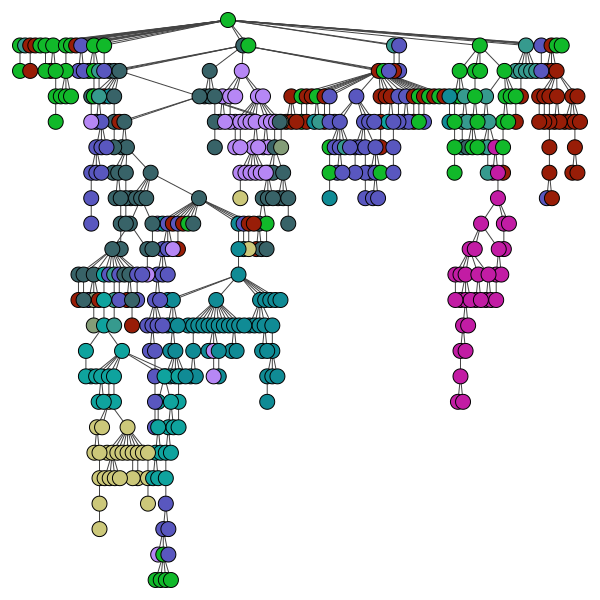

In [9]:
igraph.plot(min_span_tree_wk,target='min_sector2_wk.png',vertex_size=15,vertex_color=vector_colors,layout="tree")

Text(0.5, 0, 'Correlation Coefficient Value($\\rho_{ij}$)')

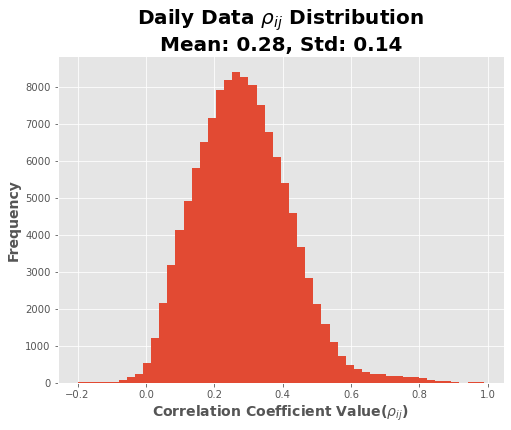

In [10]:
plt.figure(figsize=(8,6))
plt.hist(p_vec, bins=50)
plt.title(r'Daily Data $\rho_{ij}$ Distribution' + '\nMean: {:.2f}, Std: {:.2f}'.format(np.mean(p_vec),np.std(p_vec)),fontweight='bold',fontsize = 20)
plt.ylabel('Frequency',fontweight='bold',fontsize = 14)
plt.xlabel(r'Correlation Coefficient Value($\rho_{ij}$)',fontweight='bold',fontsize = 14)

Text(0.5, 0, 'Correlation Coefficient Value($\\rho_{ij}$)')

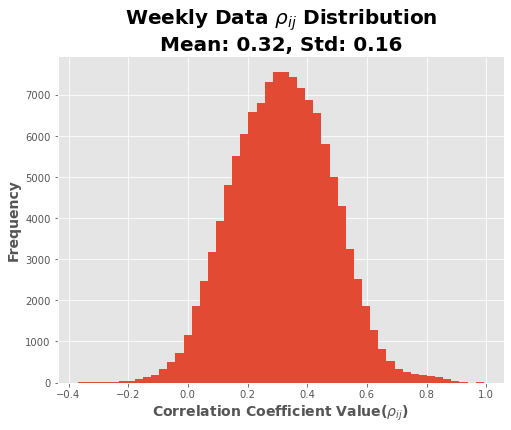

In [11]:
plt.figure(figsize=(8,6))
plt.hist(p_vec_wk, bins=50)
plt.title(r'Weekly Data $\rho_{ij}$ Distribution' + '\nMean: {:.2f}, Std: {:.2f}'.format(np.mean(p_vec_wk),np.std(p_vec_wk)),fontweight='bold',fontsize = 20)
plt.ylabel('Frequency',fontweight='bold',fontsize = 14)
plt.xlabel(r'Correlation Coefficient Value($\rho_{ij}$)',fontweight='bold',fontsize = 14)